## 랜덤포레스트

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df
    

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('../data/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('../data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('../data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('../data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('../data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

C:\Users\Master\AppData\Local\Temp\ipykernel_2424\1325660729.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[1] >0 else x[0] ,  axis=1)
C:\Users\Master\AppData\Local\Temp\ipykernel_2424\1325660729.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])


In [2]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

d:\5. ML_inflearn\.venv\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9222938581608415


In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))


d:\5. ML_inflearn\.venv\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9178


- 최적의 하이퍼 파라미터로 다시 예측 

In [6]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=8, max_depth=10, min_samples_split=8, random_state=0)

rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print(f'예측 정확도 : {accuracy_score(y_test, pred)}')

d:\5. ML_inflearn\.venv\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


예측 정확도 : 0.9175432643366135


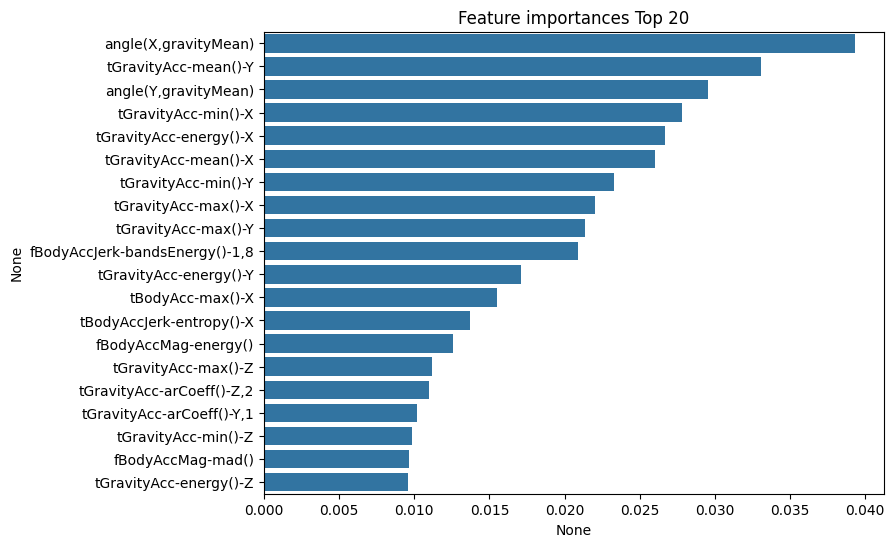

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('rf_feature_importances_top20.tif', format='tif', dpi=300, bbox_inches='tight')

## GBM(Gradient Boosting Machine)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import time

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정 
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

C:\Users\Master\AppData\Local\Temp\ipykernel_2424\1325660729.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[1] >0 else x[0] ,  axis=1)
C:\Users\Master\AppData\Local\Temp\ipykernel_2424\1325660729.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
d:\5. ML_inflearn\.venv\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = co

GBM 정확도: 0.9175
GBM 수행 시간: 951.7 초 
